In [1]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('recipe.db')
import matplotlib as plt
from geotext import GeoText

In [2]:
with open('english') as e:
    stopwords= [word.strip() for word in e]
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [3]:
sql = '''SELECT R.tag_value, S.tag_value 
         FROM recipe R 
         JOIN recipe_step RS ON R.ID = RS.recipe_id
         JOIN step S ON RS.step_id = S.ID
         WHERE R.tag_value LIKE '%tomato%' 
         AND R.tag_value LIKE '%soup%'
         ;'''

df_tomato_soup_steps = pd.read_sql(sql, conn)
print("steps")
print(df_tomato_soup_steps)

steps
                          tag_value  \
0      pepper and tomato cream soup   
1      pepper and tomato cream soup   
2      pepper and tomato cream soup   
3      pepper and tomato cream soup   
4      pepper and tomato cream soup   
...                             ...   
13035      my homestyle tomato soup   
13036      my homestyle tomato soup   
13037      my homestyle tomato soup   
13038      my homestyle tomato soup   
13039      my homestyle tomato soup   

                                               tag_value  
0      in a wide-bottomed saucepan, add tomatoes and ...  
1                            cook until peppers are limp  
2       add broth and simmer slowly for about 10 minutes  
3      stir in milk, add salt and hot pepper seasonin...  
4         mix cheese into the soup and serve immediately  
...                                                  ...  
13035                                             season  
13036  cook celery, onion, and green pepper in 1 cup 

In [4]:
sql = '''SELECT R.ID, R.tag_value, N.tag_value 
         FROM recipe R 
         JOIN recipe_ner RN ON R.ID = RN.recipe_id
         JOIN ner N ON RN.ner_id = N.ID
         WHERE R.tag_value LIKE '%fish%' 
         AND R.tag_value LIKE '%soup%'
         ;'''

df_tomato_soup_ner = pd.read_sql(sql, conn)


print("ingredients")
print(df_tomato_soup_ner.iloc[:,2:3])

ingredients
       tag_value
0         garlic
1      olive oil
2        parsley
3           salt
4     fish broth
...          ...
2188       bread
2189     mussels
2190       onion
2191         egg
2192    rockfish

[2193 rows x 1 columns]


In [5]:
freq = df_tomato_soup_ner.iloc[:,2:3].value_counts().nlargest(30)

In [6]:
freq

tag_value     
salt              110
garlic             95
tomatoes           70
water              64
onion              53
olive oil          50
white wine         45
fish               40
thyme              38
onions             37
parsley            37
celery             30
bay leaf           28
carrots            28
potatoes           26
shrimp             23
cilantro           22
butter             22
fish stock         22
mussels            20
ginger             18
soy sauce          17
scallions          17
carrot             17
cayenne pepper     16
leeks              16
fish sauce         14
red pepper         13
lemon juice        13
chicken broth      13
dtype: int64

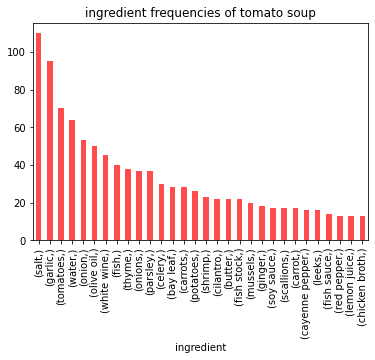

In [7]:
freq.plot(kind="bar", title = "ingredient frequencies of tomato soup", xlabel = 'ingredient', color = 'red', alpha=0.7);

In [8]:
df_tomato_soup_ner.head()

,ID,tag_value,tag_value
0,REC_1146,fish soup,garlic
1,REC_1146,fish soup,olive oil
2,REC_1146,fish soup,parsley
3,REC_1146,fish soup,salt
4,REC_1146,fish soup,fish broth


In [9]:
# add column count to recipe table
df = df_tomato_soup_ner.copy()
recipe_count = df.groupby(by="ID").count()
recipe_count = recipe_count.iloc[:,1:2].reset_index().rename(columns = {'tag_value':'count'})
dfc = df_tomato_soup_ner.merge(recipe_count, left_on='ID', right_on='ID')

In [10]:
rc = recipe_count.drop_duplicates(subset = 'ID')

In [11]:
rc.describe()

,count
count,166.000000
mean,13.210843
std,4.767072
min,3.000000
25%,10.250000
50%,13.000000
75%,16.000000
max,30.000000


<AxesSubplot:title={'center':'tomato soup ingredients frequencies'}, xlabel='Frequency', ylabel='number of ingredients'>

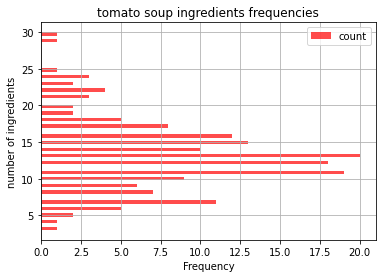

In [12]:
rc.plot(kind='hist',
        alpha=0.7,
        bins=60,
        title='tomato soup ingredients frequencies',
        grid=True,
        orientation='horizontal',
        color=['red'],
        ylabel = "number of ingredients")

# Get source information

I tried a library geotext to find a hint for the origin https://geotext.readthedocs.io/en/latest/readme.html 
It uses the words of the recipe title to get the country keys. I downloaded the country information from https://www.geonames.org/countries/

In [13]:
# Get origin
def get_origin(text):
    """ 
    function that searches for countries associated with a text
    The words of the text needs to be capitalized and seperated by a comma
    The Geotext returns a list of country abbreviations (isocodes)
    It uses the country information from https://www.geonames.org/countries/ 
    to relate the name of the country to the isocode
    
    input: Text
    output: country names seperated by space
    
    """
    freqwords = ['green', 'red', 'orange', 'yellow', 'cream', 'creamy', 'tomato', 'soup', 'leek','best']
    countries = get_countries()
    t = ""
    textlist = text.split(" ")
    textlist = [word.lower() for word in textlist if not word in stopwords and not word in freqwords]
    textlist = [word.capitalize() for word in textlist]
    text = ",".join(textlist)
    result = GeoText(text).country_mentions.keys()
    for i in result:
        try:
            t += countries.loc[countries['iso2'] == i.strip()]['country'].values[0] + ' '
        except:
            try:
                t += {countries.loc[countries['fips'] == i.strip()]['country'].values[0]} + ' '
            except:
                t = i
    return t


def get_countries():
    return pd.read_csv('countries', sep = '\t')

# Fetch the selection from the database

In [14]:
sql = '''SELECT R.tag_value
         FROM recipe R 
         JOIN recipe_ner RN ON R.ID = RN.recipe_id
         JOIN ner N ON RN.ner_id = N.ID
         WHERE R.tag_value LIKE '%tomato%' 
         AND R.tag_value LIKE '%soup%'
         ;'''

dft = pd.read_sql(sql, conn)
dft = dft.drop_duplicates()
dft

,tag_value
0,pepper and tomato cream soup
8,yellow pepper soup with fresh tomato salsa
22,tomato and pepper stewsoup
32,funked out tomato soup
42,tomatoblack bean and barley soup
...,...
12981,chunky tomato basil soup with parmesan crisp
12995,chilled tomatotarragon soup with croutons
13013,quick tomatonoodle soup
13037,flavorful tomato soup


# get top 15 origin countries and plot them

In [15]:
dft['origin'] = dft['tag_value'].apply(get_origin)
dft = dft[dft.origin != '']
dfnlargest = dft.origin.value_counts().nlargest(15)

<AxesSubplot:title={'center':'Top 15'}>

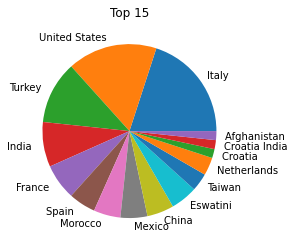

In [16]:
dfnlargest.plot(kind='pie', ylabel = '', title='Top 15')

In [17]:
dft = dft.rename(columns={'tag_value':'recipe title'})
dft.head(10)

,recipe title,origin
167,red pepper soup with sundried tomatoes and swi...,Eswatini
444,crock pot creamy italian chicken tomato soup,Italy
703,belgian potato tomato soup,Belgium
752,italian tomato garden soup,Italy
890,fennel and tomato soup with italian sausages,Italy
1202,lens tomato soup,France
1320,hearty tomato soup with chinese eggplant and g...,China
1787,mexican tomato zucchini soup recipe deweydecimal,Mexico
2307,"blt and p bacon, leek, tomato and potato soup",Netherlands
2508,turkey barley tomato soup,Turkey
